## Install and import Pandas

In [2]:

pip install pandas openpyxl


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
print("Python kernel is working")


Python kernel is working


In [4]:
import os

print("Files in ../data:")
print(os.listdir("../data"))


Files in ../data:
['QVI_transaction_data.xlsx', 'QVI_purchase_behaviour.csv']


### Data Quality Checks / Data cleaning


In [5]:
transaction_path = "../data/QVI_transaction_data.xlsx"
customer_path = "../data/QVI_purchase_behaviour.csv"

df_transactions = pd.read_excel(transaction_path)
df_customers = pd.read_csv(customer_path)

print("Transactions shape:", df_transactions.shape)
print("Customers shape:", df_customers.shape)
display(df_transactions.head())
display(df_customers.head())


Transactions shape: (264836, 8)
Customers shape: (72637, 3)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [6]:
df_transactions.info()
df_customers.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
m

In [7]:
# Convert Excel-style date to datetime
df_transactions['DATE'] = pd.to_datetime(
    df_transactions['DATE'],
    origin='1899-12-30',
    unit='D'
)

# Check conversion
df_transactions[['DATE']].head()


,DATE
0,2018-10-17
1,2019-05-14
2,2019-05-20
3,2018-08-17
4,2018-08-18


In [8]:
# Check for missing values
df_transactions.isna().sum()


DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [9]:
df_customers.isna().sum()


LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [10]:
# Outlier check
df_transactions['TOT_SALES'].describe()


count    264836.000000
mean          7.304200
std           3.083226
min           1.500000
25%           5.400000
50%           7.400000
75%           9.200000
max         650.000000
Name: TOT_SALES, dtype: float64

In [11]:
df_transactions[df_transactions['TOT_SALES'] > 100].sort_values('TOT_SALES', ascending=False)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [12]:
# Remove transactions with extremely high quantities or sales
df_transactions_clean = df_transactions[
    (df_transactions['TOT_SALES'] <= 100) &
    (df_transactions['PROD_QTY'] <= 50)
].copy()

print("Before:", df_transactions.shape)
print("After:", df_transactions_clean.shape)


Before: (264836, 8)
After: (264834, 8)


In [13]:
df_transactions_clean['TOT_SALES'].describe()


count    264834.000000
mean          7.299346
std           2.527241
min           1.500000
25%           5.400000
50%           7.400000
75%           9.200000
max          29.500000
Name: TOT_SALES, dtype: float64

### Outlier Identification and Treatment

Two extreme outliers were identified in the transaction data involving the
purchase of 200 units of Dorito Corn Chip Supreme 380g, resulting in
transaction values of $650.

These transactions occurred across two different dates for the same loyalty
card and store, indicating bulk purchasing behaviour that is not
representative of typical household consumption.

To prevent distortion of sales metrics and customer segment analysis,
transactions with total sales above $100 and product quantities above 50
units were removed from the dataset.


In [14]:
#Check for duplicates
df_customers.duplicated().sum()


np.int64(0)

In [15]:
df_transactions.duplicated().sum()


np.int64(1)

In [16]:
# drop duplicates
df_transactions_clean = df_transactions_clean.drop_duplicates()


In [17]:
df_transactions_clean.to_csv("../output/transactions_clean.csv", index=False)



## Data Merge

Now I merged the cleaned transaction and customer datasets using a left join
on the loyalty card number. This ensured all transaction records were
retained while enriching the dataset with customer demographic and
lifestage information for analysis.


In [18]:
# Merge both datasets
df_merged = df_transactions_clean.merge(
    df_customers,
    on="LYLTY_CARD_NBR",
    how="left"
)

print("Merged dataset shape:", df_merged.shape)
df_merged.head()


Merged dataset shape: (264833, 10)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [19]:
# Check for missing customer info after merge
df_merged.isna().sum()


DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [20]:
# Save merged datadsets
df_merged.to_csv("../output/quantium_merged_data.csv", index=False)


## Sales Analysis and Key Metrics

In [21]:
total_sales = df_merged['TOT_SALES'].sum()
total_transactions = df_merged['TXN_ID'].nunique()
total_customers = df_merged['LYLTY_CARD_NBR'].nunique()
avg_sales_per_txn = total_sales / total_transactions

total_sales, total_transactions, total_customers, avg_sales_per_txn


(np.float64(1933109.0), 263125, 72636, np.float64(7.346732541567696))

### Sales by Customer Lifestage

In [22]:
# Sales by customer lifestage
sales_by_lifestage = (
    df_merged
    .groupby('LIFESTAGE')['TOT_SALES']
    .sum()
    .sort_values(ascending=False)
)

sales_by_lifestage


LIFESTAGE
OLDER SINGLES/COUPLES     402420.75
RETIREES                  366470.90
OLDER FAMILIES            352467.20
YOUNG FAMILIES            316160.10
YOUNG SINGLES/COUPLES     260405.30
MIDAGE SINGLES/COUPLES    184751.30
NEW FAMILIES               50433.45
Name: TOT_SALES, dtype: float64

In [23]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


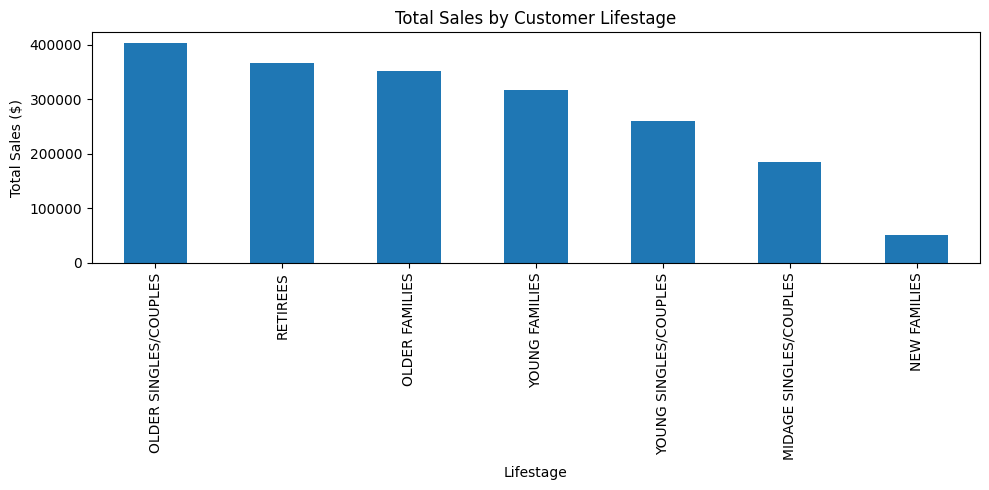

In [24]:
# Visualise sales by customer lifestage
import matplotlib.pyplot as plt

sales_by_lifestage.plot(kind='bar', figsize=(10, 5))
plt.title("Total Sales by Customer Lifestage")
plt.ylabel("Total Sales ($)")
plt.xlabel("Lifestage")
plt.tight_layout()
plt.savefig("../output/total_sales_by_lifestage.png")
plt.show()


### Sales by Premium Customer

In [25]:
# Sales by premium segment
sales_by_premium = (
    df_merged
    .groupby('PREMIUM_CUSTOMER')['TOT_SALES']
    .sum()
    .sort_values(ascending=False)
)

sales_by_premium


PREMIUM_CUSTOMER
Mainstream    750744.50
Budget        676211.55
Premium       506152.95
Name: TOT_SALES, dtype: float64

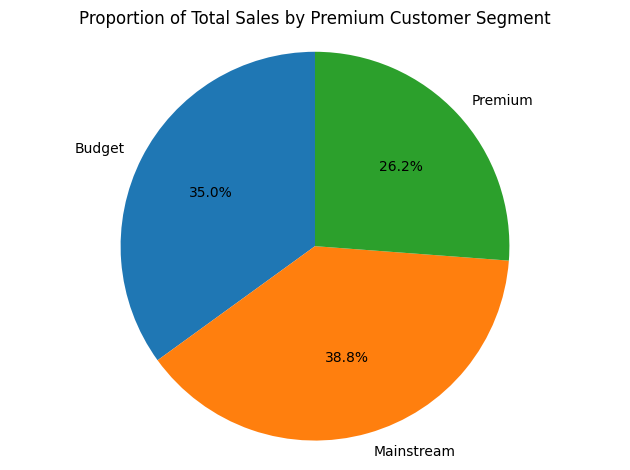

In [26]:
# Visualise sales by premium customer

# Sales by premium customer (from your results)
sales_by_premium = df_merged.groupby('PREMIUM_CUSTOMER')['TOT_SALES'].sum()

# Pie chart
plt.figure()
plt.pie(
    sales_by_premium,
    labels=sales_by_premium.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Proportion of Total Sales by Premium Customer Segment")
plt.axis('equal')  # Ensures the pie is circular
plt.tight_layout()
plt.savefig("../output/sales_by_premium_customer.png")
plt.show()


### Sales by Premium Customer Segment

Analysis of total sales by premium customer classification shows that
Mainstream customers contribute the largest share of total chip sales,
followed by Budget customers. Premium customers account for the smallest
proportion of overall sales.

This suggests that while Premium customers may have higher discretionary
spending in general, they do not contribute the highest total sales within
the chips category. Instead, Mainstream and Budget customers drive the
majority of revenue, likely due to higher purchase frequency.

As a result, marketing and promotional strategies aimed at increasing sales
volume should prioritise Mainstream and Budget customer segments.


### Purchase Frequency vs Spend per visit

In [44]:
# Transaction vs spend
segment_metrics = (
    df_merged
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        transactions=('TXN_ID', 'nunique'),
        avg_txn_value=('TOT_SALES', 'mean')
    )
    .sort_values(by='total_sales', ascending=False)
)

segment_metrics.head(10)


total_sales  transactions  \
LIFESTAGE             PREMIUM_CUSTOMER                              
OLDER FAMILIES        Budget              168363.25         22935   
YOUNG SINGLES/COUPLES Mainstream          157621.60         20783   
RETIREES              Mainstream          155677.05         21363   
YOUNG FAMILIES        Budget              139345.85         18970   
OLDER SINGLES/COUPLES Budget              136769.80         18301   
                      Mainstream          133393.80         18194   
                      Premium             132257.15         17654   
RETIREES              Budget              113147.80         15113   
OLDER FAMILIES        Mainstream          103445.55         14113   
RETIREES              Premium              97646.05         13036   

                                        avg_txn_value  
LIFESTAGE             PREMIUM_CUSTOMER                 
OLDER FAMILIES        Budget                 7.269570  
YOUNG SINGLES/COUPLES Mainstream             7.558339  
RETIREES              Mainstream             7.252262  
YOUNG FAMILIES        Budget                 7.287201  
OLDER SINGLES/COUPLES Budget                 7.430315  
                      Mainstream             7.282116  
                      Premium                7.449848  
RETIREES              Budget                 7.443445  
OLDER FAMILIES        Mainstream             7.262395  
RETIREES              Premium                7.456174

In [45]:
# Save segment metrics
segment_metrics.to_csv("../output/segment_sales_metrics.csv")


In [46]:
#Spend per transaction by segment
avg_spend_by_segment = (
    df_merged
    .groupby('LIFESTAGE')['TOT_SALES']
    .mean()
    .sort_values(ascending=False)
)

avg_spend_by_segment

LIFESTAGE
OLDER SINGLES/COUPLES     7.386849
RETIREES                  7.364325
MIDAGE SINGLES/COUPLES    7.357678
NEW FAMILIES              7.289124
OLDER FAMILIES            7.253307
YOUNG FAMILIES            7.252709
YOUNG SINGLES/COUPLES     7.158515
Name: TOT_SALES, dtype: float64

### Purchase Frequency vs Spend

Analysis of total sales by customer segment shows that the highest contributing
segments have very similar average spend per transaction, typically around
$7–$7.50.

This indicates that total sales are primarily driven by transaction frequency
rather than higher spend per visit. Segments such as Older Families (Budget)
and Retirees (Mainstream) generate high sales volumes due to frequent purchases
rather than premium pricing.

This suggests that strategies aimed at increasing purchase frequency, such as
targeted promotions or loyalty incentives, are likely to be more effective
than strategies focused solely on increasing transaction value.


### Monthly Sales Trend

In [27]:
# Create a month column
df_merged['YEAR_MONTH'] = df_merged['DATE'].dt.to_period('M')


In [28]:
# Aggregate total sales per month
monthly_sales = (
    df_merged
    .groupby('YEAR_MONTH')['TOT_SALES']
    .sum()
    .reset_index()
)

monthly_sales


,YEAR_MONTH,TOT_SALES
0,2018-07,165275.30
1,2018-08,158081.05
2,2018-09,160522.00
3,2018-10,164409.70
4,2018-11,160233.70
5,2018-12,167913.40
6,2019-01,162642.30
7,2019-02,150665.00
8,2019-03,166265.20
9,2019-04,159845.10


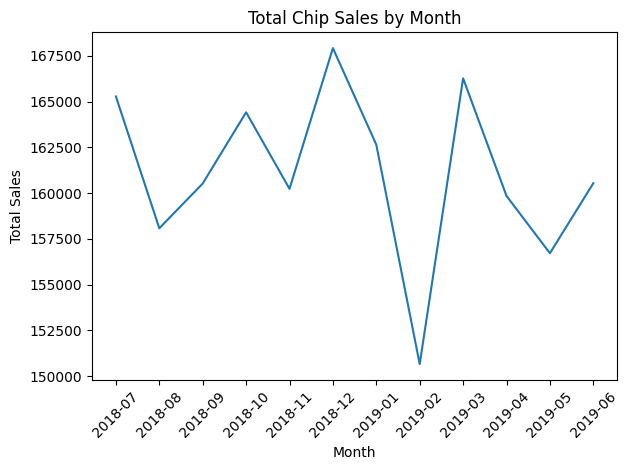

In [29]:
# Visualise monthly sales trend
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    monthly_sales['YEAR_MONTH'].astype(str),
    monthly_sales['TOT_SALES']
)
plt.title("Total Chip Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/monthly_sales_trend.png")
plt.show()


### Monthly Sales Trend

Total chip sales show a clear seasonal pattern across the year. Sales increase
steadily in the lead-up to December, which represents the highest sales month,
consistent with increased social and holiday-related consumption.

A noticeable dip occurs in February, likely reflecting post-holiday spending
behaviour and reduced social activity. Sales recover quickly from March onward,
indicating that demand remains stable across the year outside of seasonal
effects.



### Brand Analysis

In [30]:
# Extract brand as the first word of product name
df_merged['BRAND'] = (
    df_merged['PROD_NAME']
    .str.split()
    .str[0]
    .str.upper()
)

df_merged[['PROD_NAME', 'BRAND']].head()


,PROD_NAME,BRAND
0,Natural Chip Compny SeaSalt175g,NATURAL
1,CCs Nacho Cheese 175g,CCS
2,Smiths Crinkle Cut Chips Chicken 170g,SMITHS
3,Smiths Chip Thinly S/Cream&Onion 175g,SMITHS
4,Kettle Tortilla ChpsHny&Jlpno Chili 150g,KETTLE


In [31]:
# Clean inconsistent Brand names as some brands appear under multiple names
brand_mapping = {
    'RED': 'RRD',
    'SMITH': 'SMITHS',
    'DORITO': 'DORITOS',
    'INFZNS': 'INFUZIONS',
    'SNBTS': 'SUNBITES',
    'NCC': 'NATURAL',
    'GRAIN': 'GRNWVES',
    'WW': 'WOOLWORTHS'
}

df_merged['BRAND'] = df_merged['BRAND'].replace(brand_mapping)


In [32]:
# Chechk quantity of each brand sold
brand_counts = (
    df_merged
    .groupby('BRAND')['PROD_QTY']
    .sum()
    .sort_values(ascending=False)
)

brand_counts.head(10)


BRAND
KETTLE        79051
SMITHS        60337
DORITOS       53816
PRINGLES      48019
RRD           33646
WOOLWORTHS    27856
INFUZIONS     27119
THINS         26929
COBS          18571
TOSTITOS      18134
Name: PROD_QTY, dtype: int64

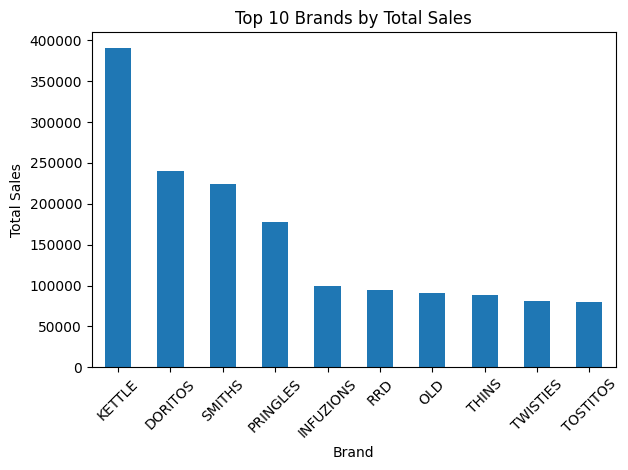

In [33]:
# Visualise top 10 brands by sales
brand_sales = (
    df_merged
    .groupby('BRAND')['TOT_SALES']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
brand_sales.plot(kind='bar')
plt.title("Top 10 Brands by Total Sales")
plt.ylabel("Total Sales")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/top_10_brands_by_sales.png")
plt.show()


### Brand Affinity Testing
It helps identify which brands are especially popular with a target segment and where targeted promotions are most likely to be effective.

In [34]:
target = df_merged[
    (df_merged['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (df_merged['PREMIUM_CUSTOMER'] == 'Mainstream')
]

other = df_merged.drop(target.index)

brand_share_target = target.groupby('BRAND')['PROD_QTY'].sum()
brand_share_other = other.groupby('BRAND')['PROD_QTY'].sum()

affinity = (brand_share_target / brand_share_target.sum()) / \
           (brand_share_other / brand_share_other.sum())

affinity.sort_values(ascending=False).head(10)


BRAND
TYRRELLS     1.236230
TWISTIES     1.227396
KETTLE       1.203818
TOSTITOS     1.203633
OLD          1.196953
PRINGLES     1.194531
DORITOS      1.167171
COBS         1.150696
INFUZIONS    1.140942
THINS        1.066440
Name: PROD_QTY, dtype: float64

Brand Affinity Analysis with focus on Mainstream-Young Singles/Couples

In [35]:
# Define target population vs rest of the population
target_segment = df_merged[
    (df_merged['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (df_merged['PREMIUM_CUSTOMER'] == 'Mainstream')
]

other_segment = df_merged.drop(target_segment.index)


In [36]:
# Calculate brand affinity
# Brand proportions (share of quantity)
brand_target = (
    target_segment.groupby('BRAND')['PROD_QTY'].sum()
    / target_segment['PROD_QTY'].sum()
)

brand_other = (
    other_segment.groupby('BRAND')['PROD_QTY'].sum()
    / other_segment['PROD_QTY'].sum()
)

# Combine into a DataFrame with explicit column names
brand_affinity = pd.DataFrame({
    'target': brand_target,
    'other': brand_other
}).dropna()

# Affinity index
brand_affinity['AFFINITY_INDEX'] = brand_affinity['target'] / brand_affinity['other']

brand_affinity.sort_values('AFFINITY_INDEX', ascending=False).head(10)




,target,other,AFFINITY_INDEX
BRAND,,,
TYRRELLS,0.029587,0.023933,1.236230
TWISTIES,0.043306,0.035283,1.227396
KETTLE,0.185649,0.154217,1.203818
TOSTITOS,0.042581,0.035377,1.203633
OLD,0.041598,0.034753,1.196953
PRINGLES,0.111980,0.093744,1.194531
DORITOS,0.122877,0.105278,1.167171
COBS,0.041856,0.036375,1.150696
INFUZIONS,0.060649,0.053157,1.140942


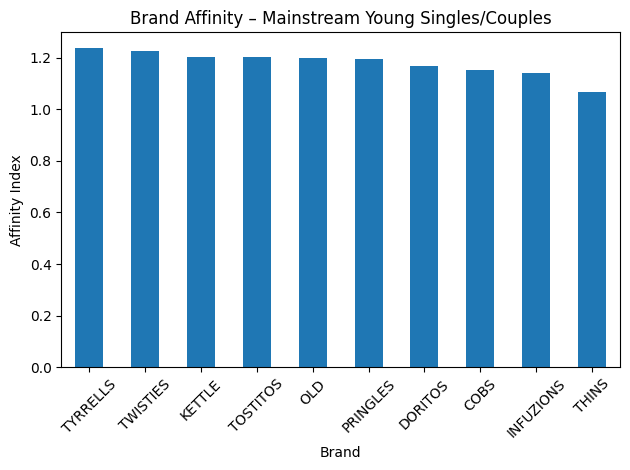

In [37]:
# Visualise brand affinity
import matplotlib.pyplot as plt

top_affinity = brand_affinity.sort_values('AFFINITY_INDEX', ascending=False).head(10)

plt.figure()
top_affinity['AFFINITY_INDEX'].plot(kind='bar')
plt.title("Brand Affinity – Mainstream Young Singles/Couples")
plt.ylabel("Affinity Index")
plt.xlabel("Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/brand_affinity_mainstream_young.png")
plt.show()


### Brand Preferences – Mainstream Young Singles/Couples

The analysis shows that Mainstream young singles and couples consistently
purchase certain chip brands more often than other customer groups. In
particular, brands such as Tyrells, Twisties, Kettle, Tostitos, and Pringles are
especially popular with this segment.

This indicates that brand choice plays an important role in purchasing
decisions for young singles and couples. Focusing promotions and product
visibility on these preferred brands is likely to be an effective way to
increase sales within this customer group.


### Packet Size Preference

In [ ]:
# Extract packet size (grams) from product name
df_merged['PACK_SIZE'] = (
    df_merged['PROD_NAME']
    .str.extract(r'(\d+)')
    .astype(float)
)

df_merged[['PROD_NAME', 'PACK_SIZE']].head()


,PROD_NAME,PACK_SIZE
0,Natural Chip Compny SeaSalt175g,175.0
1,CCs Nacho Cheese 175g,175.0
2,Smiths Crinkle Cut Chips Chicken 170g,170.0
3,Smiths Chip Thinly S/Cream&Onion 175g,175.0
4,Kettle Tortilla ChpsHny&Jlpno Chili 150g,150.0


In [ ]:
# Packet size preference by customer segment
packet_size_by_segment = (
    df_merged
    .groupby('LIFESTAGE')['PACK_SIZE']
    .mean()
    .sort_values(ascending=False)
)

packet_size_by_segment


LIFESTAGE
YOUNG SINGLES/COUPLES     183.126728
MIDAGE SINGLES/COUPLES    182.720868
RETIREES                  182.674658
OLDER SINGLES/COUPLES     182.386339
OLDER FAMILIES            182.152858
YOUNG FAMILIES            181.906221
NEW FAMILIES              181.371152
Name: PACK_SIZE, dtype: float64

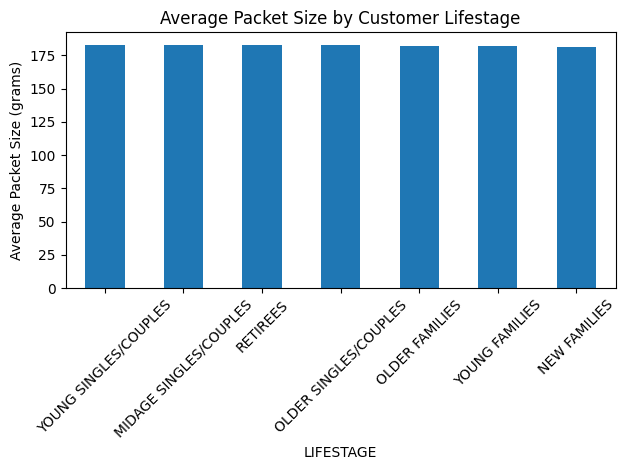

In [ ]:
# Visualise packet size by segment
import matplotlib.pyplot as plt

packet_size_by_segment.plot(kind='bar')
plt.title("Average Packet Size by Customer Lifestage")
plt.ylabel("Average Packet Size (grams)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/avg_packet_size_by_lifestage.png")
plt.show()


### Packet Size Preference

Analysis of average packet size by customer lifestage shows minimal variation
across all segments, with average packet sizes consistently around 180g.

This indicates that packet size preference does not significantly differ
between customer groups and is unlikely to be a key driver of purchasing
behaviour. As a result, product size is not considered a primary factor for
segment-specific targeting strategies.


### Summary Table of Key Insights

In [ ]:
# Create a summary table of key insights
key_insights = pd.DataFrame({
    "Insight Area": [
        "Sales Driver",
        "Spend per Transaction",
        "Packet Size Preference",
        "Premium Customer Contribution",
        "Seasonality",
        "Brand Preference (Young Singles/Couples)"
    ],
    "Key Finding": [
        "Sales are driven by how often customers purchase rather than how much they spend per visit.",
        "Average spend per transaction is consistent across all customer segments.",
        "Average packet size is similar across customer lifestages, indicating no strong size preference.",
        "Mainstream customers contribute the largest share of total sales.",
        "Sales peak in December and dip in February, showing clear seasonal patterns.",
        "Young singles and couples prefer specific brands such as Tyrells, Kettle, and Twisties."
    ],
    "Business Implication": [
        "Focus strategies on increasing purchase frequency rather than increasing basket value.",
        "Upselling is less effective than encouraging repeat purchases.",
        "Segment-specific product sizing strategies are unlikely to drive significant growth.",
        "Marketing efforts should prioritise Mainstream customers to maximise revenue impact.",
        "Promotions should be intensified before December and targeted during low-demand months.",
        "Targeted promotions and product placement for preferred brands can increase engagement."
    ]
})

key_insights





,Insight Area,Key Finding,Business Implication
0,Sales Driver,Sales are driven by how often customers purcha...,Focus strategies on increasing purchase freque...
1,Spend per Transaction,Average spend per transaction is consistent ac...,Upselling is less effective than encouraging r...
2,Packet Size Preference,Average packet size is similar across customer...,Segment-specific product sizing strategies are...
3,Premium Customer Contribution,Mainstream customers contribute the largest sh...,Marketing efforts should prioritise Mainstream...
4,Seasonality,"Sales peak in December and dip in February, sh...",Promotions should be intensified before Decemb...
5,Brand Preference (Young Singles/Couples),Young singles and couples prefer specific bran...,Targeted promotions and product placement for ...


In [ ]:
key_insights.to_csv("../output/key_insights_summary.csv", index=False)


### Recommendation and Conclusion

The analysis shows that total chip sales are primarily driven by purchase
frequency rather than spend per transaction, as average spend and packet size
remain consistent across customer segments. Mainstream customers contribute the
largest share of total sales compared to Budget and Premium customers,
indicating that this group represents the core revenue base for the category.

Within this group, Older Singles/Couples generate the highest total sales and
display stable, habitual purchasing behaviour. For this segment, the priority
should be maintaining strong product availability and minimising disruption to
existing buying patterns in order to protect and sustain core revenue.

Sales also exhibit a clear seasonal pattern, with a strong uplift in the
lead-up to December and a dip in February. Promotional activity should therefore
be intensified ahead of peak seasonal periods to maximise returns, while
targeted incentives during lower-demand months may help smooth sales volatility.

Although Young Singles/Couples contribute less total revenue than older
segments, they show clearer brand preferences and greater responsiveness to
brand-led strategies. Brand affinity analysis identifies specific brands that
resonate strongly with this group, making them suitable targets for focused
promotions, product placement, and increased visibility.

By prioritising Mainstream customers overall, protecting revenue from Older
Singles/Couples, leveraging seasonality to time promotions effectively, and
using brand-led strategies to influence purchasing behaviour among Young
Singles/Couples, the business can balance revenue stability with opportunities
for incremental category growth.
